### Dataset can be downloaded from https://www.unb.ca/cic/datasets/ids-2017.html or you can directly below shell
You need to just unzip and put it same directory with this CNN.ipynb file

### Download dataset directly and unzip

In [2]:
# !gdown --id 1-t3RdDpmqMs4ABt9oobSapeNYTZJ9tpu
# !unzip MachineLearningCSV.zip

In [3]:
import os
from os.path import join
import glob
import pandas as pd
import numpy as np
import time
from preprocessing import balance_data, normalize,load_data
%load_ext autoreload

### Set dataset path

In [4]:
dataroot = 'MachineLearningCVE/'

In [5]:
%autoreload 2
X,y = load_data(dataroot) # reads csv file and returns np array of X,y -> of shape (N,D) and (N,1)

MachineLearningCVE/*.csv
['MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv', 'MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv', 'MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv', 'MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv']
There are 2830743 flow records with 79 feature dimension
Data loaded.
Data preprocessing started...
Stripped column names with whitespaces
remove unnecessary columns:  ['Flow Packets/s', 'Flow Bytes/s', 'Label']
There are 0 nan entries
Converted to numeric


## Data Imbalance
1. It is curucial to adress this issue in order to get decent performance
2. It also affects evaluation, we should calculate  `balanced accuracy`

In [6]:
X = normalize(X)

Set random seed

In [7]:
SEED = 42

#### X and y dataset shapes

In [8]:
print(X.shape)
print(y.shape)

(2830743, 76)
(2830743,)


In [9]:

# %autoreload 2
from models import Classifier

def ensure_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

def getClassifier(args,runs_dir=None):
    (method,optim,lr,reg,batch_size,input_dim,num_class,num_epochs) = args
    if runs_dir is not None:
        ensure_dir(runs_dir)
    
    clf = Classifier(method,input_dim,num_class,lr=lr,reg=reg,num_epochs=num_epochs,
                        batch_size=batch_size,runs_dir=runs_dir)
    return clf


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
K=5
skf = StratifiedKFold(n_splits=K,random_state=SEED, shuffle=True)
for fold_index, (train_index,test_index) in enumerate(skf.split(X,y)):# runs only once 
        print('---------------------------------------------')
        print('Fold #{}'.format(fold_index))    
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        break

---------------------------------------------
Fold #0


In [11]:
import torch 
torch.set_num_threads(50)

In [12]:

#hyper-params
batch_size = 5*1024 # increasing batch size with more gpu added
optim = 'Adam'

input_dim = X_train.shape[1]
num_class = len(np.unique(y_train))
num_epochs = 10
learning_rates = [1e-3]
regularizations = [1e-3]


accuracies = {}
best_model = None
best_acc = -1
architecture = '1D-CNN_conv_5_fc_1'
run_number = 5
method='cnn5'

for lr in learning_rates:
    for reg in regularizations:
        print (reg, lr)
        classifier_args = (method,optim,lr,reg,batch_size,input_dim,num_class,num_epochs)
        config =  '{}/{}th_run/optim_{}_lr_{}_reg_{}_bs_{}'.format(architecture,run_number,optim,lr,reg,batch_size)
        runs_dir = join(dataroot,'runs',config)
        
        X_train = X_train.astype(float)
        y_train = y_train.astype(int)
        p = np.random.permutation(len(y_train))
        X_train = X_train[p]
        y_train = y_train[p]
        print ('balancing data ...')
        X_train,y_train = balance_data(X_train,y_train,seed=SEED)
        
        tick = time.time()
        clf = getClassifier(classifier_args,runs_dir)
        print ('Fit data to model.')
        clf.fit(X_train,y_train)
        pred = clf.predict(X_test,eval_mode=True)
        print ('Try prediction .. ')
        acc = metrics.balanced_accuracy_score(y_test,pred)
        if acc >best_acc:
            best_model = clf
            best_acc = acc
        accuracies[(lr,reg)]=acc
        tock = time.time()
        print("Model is trained in {} sec".format(tock-tick))

0.001 0.001
balancing data ...
Fit data to model.
Loaded MachineLearningCVE/runs/1D-CNN_conv_5_fc_1/5th_run/optim_Adam_lr_0.001_reg_0.001_bs_5120 model trained with batch_size = 5120, seen 6 epochs and 105 mini batches
Loaded MachineLearningCVE/runs/1D-CNN_conv_5_fc_1/5th_run/optim_Adam_lr_0.001_reg_0.001_bs_5120 model trained with batch_size = 5120, seen 8 epochs and 157 mini batches
Try prediction .. 
Model is trained in 6039.44033074379 sec


In [13]:
# accuracies for CV
for x in accuracies:
    print(x)
    print(accuracies[x])
results = accuracies  

(0.001, 0.001)
0.8712701803805607


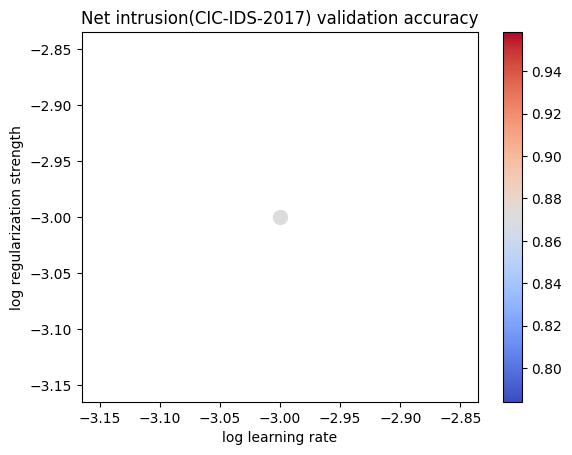

In [14]:
# Visualize the cross-validation results
import math
import matplotlib.pyplot as plt
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]


# plot validation accuracy
marker_size=100
colors = [results[x] for x in results] # default size of markers is 20

plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Net intrusion(CIC-IDS-2017) validation accuracy')
plt.savefig('MachineLearningCVE/method_{}_arch_run_{}-2.png'.format(method,architecture,run_number))
plt.show()

In [15]:
results

{(0.001, 0.001): 0.8712701803805607}

In [30]:
from torchsummary import summary
summary(clf.model, (76,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 76]             256
       BatchNorm1d-2               [-1, 64, 76]             128
              ReLU-3               [-1, 64, 76]               0
            Conv1d-4              [-1, 128, 76]          24,704
       BatchNorm1d-5              [-1, 128, 76]             256
              ReLU-6              [-1, 128, 76]               0
            Conv1d-7              [-1, 256, 76]          98,560
       BatchNorm1d-8              [-1, 256, 76]             512
              ReLU-9              [-1, 256, 76]               0
           Conv1d-10              [-1, 256, 76]         196,864
      BatchNorm1d-11              [-1, 256, 76]             512
             ReLU-12              [-1, 256, 76]               0
           Conv1d-13              [-1, 128, 76]          98,432
      BatchNorm1d-14              [-1, 

In [28]:
X_train.shape[1]

76

In [21]:
clf.model

CNN5(
  (conv): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
  )
  (classifier): Sequent